# Convolutional Neural Networks with PyTorch Exercise 



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import torch.optim as optim
from PIL import Image

import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Part 1. Load the Dataset 

We will use a subset of the [WikiArt Dataset](https://paperswithcode.com/dataset/wikiart) containing 3,988 paintings by 10 artists. The artists are Cezanne, Degas, Gauguin, Hassam, Matisse, Monet, Pissarro, Renoir, Sargent, and VanGogh.

The file `Paintings.zip` in the `data` directory contains a subdirectory called `images` that contains all 3,988 images, a file `labels.csv` with the labels for all images, and a file `label_names.csv` with the names of the painters that correspond to the labels.

Follow the explanations in Lecture 18 and load the Paintings dataset. During the data loading, resize the images to 224x224 pixels size.

In [ ]:

# uncompress the code

!unzip -uq '/content/drive/MyDrive/Colab Notebooks/cs504/assignment5/data/Paintings.zip' -d '/content/drive/MyDrive/Colab Notebooks/cs504/assignment5/data/Paintings/'

In [74]:
class MyDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.root_dir = root_dir
        self.image_folder = os.path.join(root_dir, 'images')
        self.labels_file = pd.read_csv(os.path.join(root_dir, 'labels.csv'), header=None)
        self.transform = transform

    def __len__(self):
        return len(self.labels_file)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, f'img_{idx + 1:04}.jpg')
        image = Image.open(img_name)
        image = self.transform(image)
        label = self.labels_file.iloc[idx, 0]

        return image, label


In [76]:
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

In [77]:
dataset = MyDataset(root_dir='/content/drive/MyDrive/Colab Notebooks/cs504/assignment5/data/Paintings/Paintings/', transform=transform)

Instantiate the train, test, and validation datasets. Use 20% for testing, and 20% of the initial training set for validation. Print the number of samples in the train, test, and validation datasets.

In [ ]:

from sklearn.model_selection import train_test_split

train_indices_1, test_indices = train_test_split(
    range(len(dataset)), test_size = 0.2, random_state = 123)

train_indices, val_indices = train_test_split(
    range(len(train_indices_1)), test_size = 0.2, random_state = 123)


In [10]:
train_data = Subset(dataset, train_indices)
test_data = Subset(dataset, test_indices)
val_data = Subset(dataset, val_indices)

In [11]:
print('Train data: ', len(train_data))
print('Test data: ', len(test_data))
print('Validation data: ', len(val_data))

Train data:  2551
Test data:  798
Validation data:  638


Use `DataLoader` to create iterable objects over batches of images and labels for the datasets. Select a batch size of 64 images and labels.

In [ ]:

train_dataloader = DataLoader(train_data, shuffle = True, batch_size = 64)
test_dataloader = DataLoader(test_data, shuffle = False, batch_size = 64)
val_dataloader = DataLoader(val_data, shuffle = False, batch_size = 64)

Use the `make_grid()` function to plot images from the training dataset.

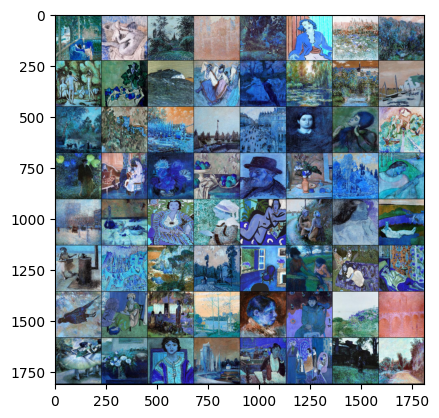

In [ ]:

# define a function imshow
def imshow(imgs):
  npimage = imgs.numpy()
  imgs = np.transpose(npimage,(1,2,0))
  plt.imshow(imgs)

# get a batch of images
images,labels = next(iter(train_dataloader))

imshow(torchvision.utils.make_grid(images))

## Part 2. Define the Model 

Let's use again a pretrained VGG-16 model. Create an instance of the model, e.g., called `model_1` and replace the final layer with a custom layer to output 10 class probabilities.

In [ ]:

from torchvision.models import vgg16

model_1 = vgg16(pretrained = True)
model_1.classifier._modules['6'] = nn.Linear(4096,10)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Move the model to the GPU device.

In [51]:
model_1.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Part 3. Train and Evaluate the Model

Train the model, plot the learning curves, and evaluate the performance on the test dataset. Use Adam optimizer with 1e-4 learning rate. The expected test accuracy should be around 70%.

In [79]:
# train the model for one epoch on the given set
def train(model, train_loader, criterion, optimizer, epoch):
    running_loss, total, sum_correct = 0.0, 0, 0

    # indicate this is a training step
    model.train()

    for i, data in enumerate(train_loader):
        images, labels = data
        labels = labels.type(torch.LongTensor)
        images, labels = images.to(device), labels.to(device)

        # forward + loss + backward + update
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # calculate loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        sum_correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # return the accuracy and loss
    return sum_correct/total, running_loss


# evaluate the model on the given set
def validate(model, val_loader, criterion):
    running_loss, total, sum_correct = 0.0, 0, 0

    # indicate this is an evaluation step
    model.eval()

    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            labels = labels.type(torch.LongTensor)
            images, labels = images.to(device), labels.to(device)

            # Compute the output: forward pass only
            outputs = model(images)
            loss = criterion(outputs, labels)

            # calculate loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            sum_correct += (predicted == labels).sum().item()

    # return the accuracy and loss
    return sum_correct/total, running_loss

In [80]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1.parameters(), lr = 1e-4)

In [82]:
# total number of training epochs
epoch_num = 10

# initialize variables to save the training and validation loss and accuracy
training_loss_plot = []
training_accuracy_plot = []
val_loss_plot = []
val_accuracy_plot = []

# loop over the number of epochs
for epoch in range(epoch_num):

    # train for one epoch: return accuracy and loss
    tr_accuracy, tr_loss = train(model_1, train_dataloader, criterion, optimizer, epoch)

    # evaluate after each epoch: return accuracy and loss
    val_accuracy, val_loss = validate(model_1, val_dataloader, criterion)

    # append the accuracies and losses after each epoch
    training_accuracy_plot.append(tr_accuracy)
    training_loss_plot.append(tr_loss)
    val_accuracy_plot.append(val_accuracy)
    val_loss_plot.append(val_loss)

    # Display after each epoch
    print(f'Epoch: {epoch + 1}/{epoch_num}\t Training loss: {tr_loss:.3f}\t',
              f'Training accuracy: {100*tr_accuracy:2.3f}\t Validation accuracy: {100*val_accuracy:2.3f}')

Epoch: 1/10	 Training loss: 66.737	 Training accuracy: 39.044	 Validation accuracy: 57.524
Epoch: 2/10	 Training loss: 41.925	 Training accuracy: 63.387	 Validation accuracy: 68.339
Epoch: 3/10	 Training loss: 26.810	 Training accuracy: 76.088	 Validation accuracy: 71.003
Epoch: 4/10	 Training loss: 13.329	 Training accuracy: 88.906	 Validation accuracy: 74.765
Epoch: 5/10	 Training loss: 7.373	 Training accuracy: 93.571	 Validation accuracy: 69.749
Epoch: 6/10	 Training loss: 5.554	 Training accuracy: 96.158	 Validation accuracy: 70.063
Epoch: 7/10	 Training loss: 4.300	 Training accuracy: 96.825	 Validation accuracy: 77.273
Epoch: 8/10	 Training loss: 2.886	 Training accuracy: 97.530	 Validation accuracy: 70.063
Epoch: 9/10	 Training loss: 2.214	 Training accuracy: 98.354	 Validation accuracy: 72.727
Epoch: 10/10	 Training loss: 2.240	 Training accuracy: 98.314	 Validation accuracy: 77.900


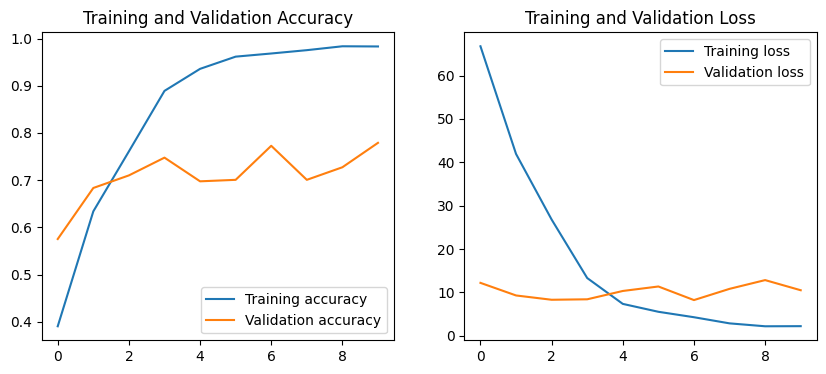

In [84]:
# plot the accuracy and loss for the training and validation datasets
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.plot(training_accuracy_plot)
plt.plot(val_accuracy_plot)
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.title('Training and Validation Accuracy')
plt.subplot(1,2,2)
plt.plot(training_loss_plot)
plt.plot(val_loss_plot)
plt.legend(['Training loss', 'Validation loss'])
plt.title('Training and Validation Loss')
plt.show()

In [85]:
# evaluate model on test data

# calculate the accuracy and loss on the test dataset
test_accuracy, test_loss = validate(model_1, test_dataloader, criterion)
print(f'Test dataset accuracy: {100*test_accuracy:2.3f}')

Test dataset accuracy: 69.799


## Part 4. Train and Evaluate the Model with a Pretrained ResNet50 Model

Similarly to the VGG-16 model, import a pretrained ResNet50 model as `model_2`, and afterward train and evaluate the model on the Paintings dataset. Similarly to `model_1` use Adam optimizer with a learning rate of 1e-4. The expected test accuracy should be around 80%.

In [86]:
model_2 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [ ]:

'''
Note:
The last layer can be changed to:
model_2.fc = nn.Linear(2048, num_classes)
'''
model_2.fc = nn.Linear(2048, 10)
model_2.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layers): Sequential(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

In [88]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_2.parameters(), lr = 1e-4)

In [89]:
# total number of training epochs
epoch_num = 10

# initialize variables to save the training and validation loss and accuracy
training_loss_plot = []
training_accuracy_plot = []
val_loss_plot = []
val_accuracy_plot = []

# loop over the number of epochs
for epoch in range(epoch_num):

    # train for one epoch: return accuracy and loss
    tr_accuracy, tr_loss = train(model_2, train_dataloader, criterion, optimizer, epoch)

    # evaluate after each epoch: return accuracy and loss
    val_accuracy, val_loss = validate(model_2, val_dataloader, criterion)

    # append the accuracies and losses after each epoch
    training_accuracy_plot.append(tr_accuracy)
    training_loss_plot.append(tr_loss)
    val_accuracy_plot.append(val_accuracy)
    val_loss_plot.append(val_loss)

    # Display after each epoch
    print(f'Epoch: {epoch + 1}/{epoch_num}\t Training loss: {tr_loss:.3f}\t',
              f'Training accuracy: {100*tr_accuracy:2.3f}\t Validation accuracy: {100*val_accuracy:2.3f}')

Epoch: 1/10	 Training loss: 69.479	 Training accuracy: 45.472	 Validation accuracy: 66.614
Epoch: 2/10	 Training loss: 25.940	 Training accuracy: 82.046	 Validation accuracy: 77.116
Epoch: 3/10	 Training loss: 7.922	 Training accuracy: 96.119	 Validation accuracy: 80.251
Epoch: 4/10	 Training loss: 2.296	 Training accuracy: 99.255	 Validation accuracy: 80.251
Epoch: 5/10	 Training loss: 0.916	 Training accuracy: 99.726	 Validation accuracy: 80.721
Epoch: 6/10	 Training loss: 0.463	 Training accuracy: 99.961	 Validation accuracy: 81.034
Epoch: 7/10	 Training loss: 0.292	 Training accuracy: 100.000	 Validation accuracy: 80.878
Epoch: 8/10	 Training loss: 0.182	 Training accuracy: 100.000	 Validation accuracy: 80.094
Epoch: 9/10	 Training loss: 0.139	 Training accuracy: 100.000	 Validation accuracy: 80.094
Epoch: 10/10	 Training loss: 0.123	 Training accuracy: 100.000	 Validation accuracy: 79.781


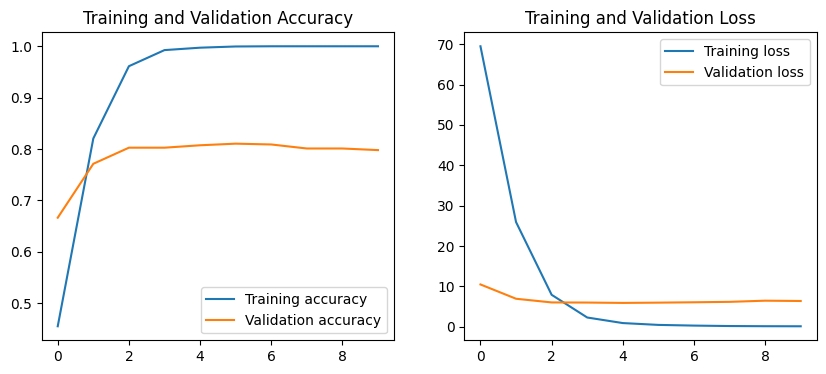

In [90]:
# plot the accuracy and loss for the training and validation datasets
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.plot(training_accuracy_plot)
plt.plot(val_accuracy_plot)
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.title('Training and Validation Accuracy')
plt.subplot(1,2,2)
plt.plot(training_loss_plot)
plt.plot(val_loss_plot)
plt.legend(['Training loss', 'Validation loss'])
plt.title('Training and Validation Loss')
plt.show()


In [93]:
# evaluate model on test data

# calculate the accuracy and loss on the test dataset
test_accuracy, test_loss = validate(model_2, test_dataloader, criterion)
print(f'Test dataset accuracy: {100*test_accuracy:2.3f}')


Test dataset accuracy: 71.930


## Part 5. Save and Load the Model Parameters 

Save the state dictionary for `model_2`.

In [ ]:

torch.save(model_2.state_dict(),'model_2_weights.pth')

Load the state dictionary and evaluate the performance on the test dataset to ensure that the accuracy is the same.

In [ ]:

model_3 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
model_3.fc = nn.Linear(2048,10)
model_3.load_state_dict(torch.load('model_2_weights.pth'))
model_3.to(device)

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layers): Sequential(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

In [96]:
# calculate the accuracy and loss on the test dataset
test_accuracy, test_loss = evaluate(model_3, test_dataloader, criterion)
print(f'Test dataset accuracy: {test_accuracy:2.4f}')

Test dataset accuracy: 0.7193
